This code runs Deep Learning on nutau and nue samples created by Dasha. 

This code runs in a python 3.7 conda environment constructed as follows:
- conda create --name tf-gpu tensorflow-gpu keras scikit-learn matplotlib ipykernel nb_conda_kernels [Pillow]
- conda activate tf-gpu
(Pillow is for image manipulation for making heat maps, but I haven't got it to work yet.  Can remove from environment.)

To run with multiple GPUs on CyberLAMP you must specify the "nodes" and "gpus" qualifiers in the same chunk.  For example:
- qsub -I -A cyberlamp -l qos=cl_higpu -l nodes=1:ppn=1:gpus=4:shared -l mem=24gb -l walltime=4:00:00

In [1]:
import os

# Set which GPU to use.  This probably needs to be done before any other CUDA vars get defined.
# Use the command "nvidia-smi" to get association of a particular GPU with a particular number.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [2]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.utils import shuffle

In [3]:
c =0.299792458
n =1.3195
v=c/n 
print(v)

0.2272015596816976


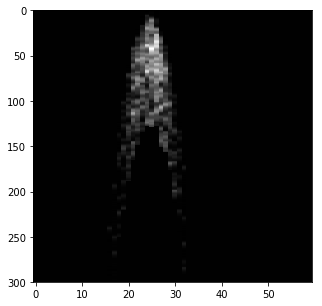

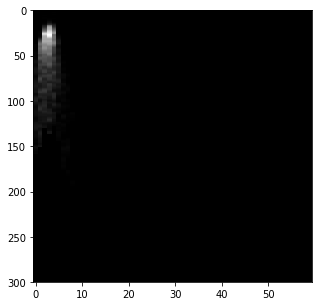

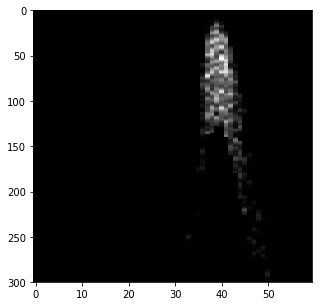

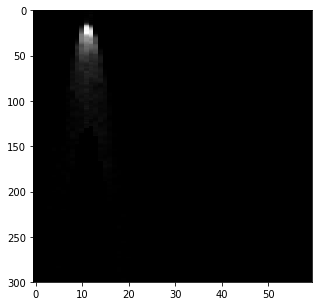

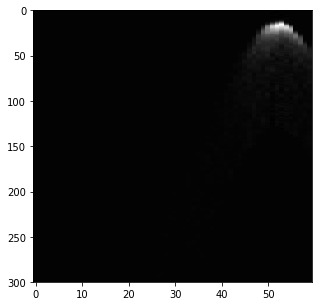

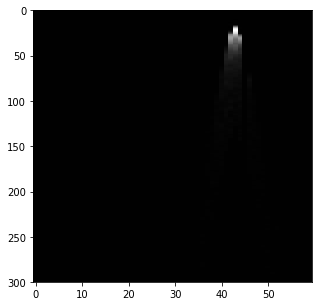

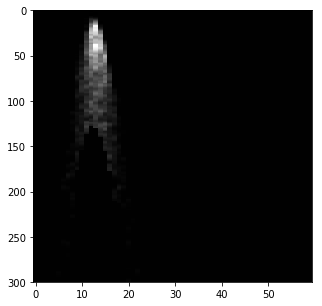

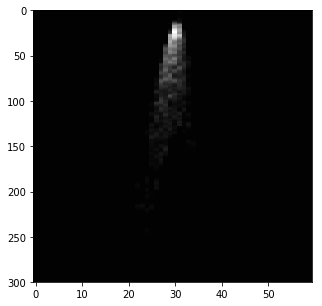

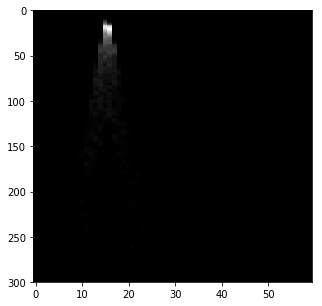

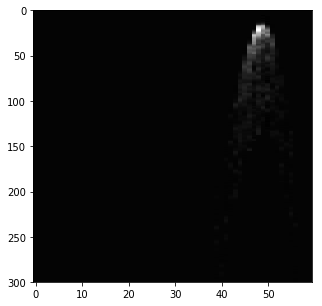

In [6]:
nu_size = 2402105
nu_data = np.memmap('/fastio2/dasha/double_pulse/nu_data_qs5000_qt10000.npy', mode = 'r', dtype ='float32', shape = (nu_size,300,60))
for i in nu_data[:10]:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.imshow(i, interpolation='nearest', aspect='auto', cmap= 'gray')

In [7]:
print(np.amax(nu_data))
print(np.amin(nu_data))

7.484466e-09
-1.6344187e-10


In [8]:
nu_labels = np.memmap('/fastio2/dasha/double_pulse/nu_label_qs5000_qt10000.npy', mode = 'r', dtype ='float32', shape = (nu_size))
labels = []
for i in nu_labels:
    if i == 4:
        labels.append([0,0,1])
    elif i == 2:
        labels.append([0,1,0])
    else:
        labels.append([1,0,0])
labels = np.array(labels)
print(labels.shape)
print(labels[0:10])


(2402105, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [15]:
print(labels[1400000:1400010])

[[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [14]:
print(sum(labels))

[1243137  849663  309305]


In [ ]:
idx = np.arange(nu_size)
np.random.shuffle(idx)
print(idx[:10])

In [17]:
train_idx = idx[:100000] 
test_idx = idx[100000:130000] 
valid_idx = idx[130000:160000]

In [18]:
train_data = []
train_labels = []
test_data = []
test_labels = []
valid_data = []
valid_labels = []

for i in train_idx:
    train_data.append(nu_data[i])
    train_labels.append(labels[i])
for i in test_idx:
    test_data.append(nu_data[i])
    test_labels.append(labels[i])
for i in valid_idx:
    valid_data.append(nu_data[i])
    valid_labels.append(labels[i])

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
    

In [19]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(100000, 300, 60) (100000, 3)
(30000, 300, 60) (30000, 3)
(30000, 300, 60) (30000, 3)


In [20]:
print(sum(train_labels))
print(sum(test_labels))
print(sum(valid_labels))

[51883 35205 12912]
[15455 10622  3923]
[15502 10561  3937]


In [21]:
train_data = train_data.reshape((len(train_data),300,60,1))
train_data = train_data.astype('float32')/10**-8
mean = np.mean(train_data)
std = np.std(train_data)
print(mean,std)
train_data = train_data - mean
train_data = train_data/std

valid_data = valid_data.reshape((len(valid_data),300,60,1))
valid_data = valid_data.astype('float32')/10**-8
valid_data = valid_data - mean
valid_data = valid_data/std

test_data = test_data.reshape((len(test_data),300,60,1))
test_data = test_data.astype('float32')/10**-8
test_data = test_data - mean
test_data = test_data/std

0.0011251965 0.013635723


In [22]:
print(np.amax(train_data))
print(np.amin(train_data))

48.39595
-0.85883564


In [23]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [24]:
#for im in data_d[:100]:
#    print(im.shape)
#    fig = plt.figure(figsize=(12, 12))
#    ax = fig.add_subplot(111)
#    ax.imshow(im, interpolation='nearest', aspect='auto', cmap= 'gray')
    #ax.plot(im[14,:])
    #print(im[:,46])

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 60, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

W0830 12:12:51.149417 140039114741504 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 12:12:51.174200 140039114741504 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 12:12:51.224446 140039114741504 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 12:12:51.383730 140039114741504 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0830 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 58, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 29, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 27, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 5, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 3, 128)        147584    
__________

In [26]:
from keras import optimizers
import tensorflow as tf

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

sgd = optimizers.SGD(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
#              options = run_opts)

W0830 12:13:24.282676 140039114741504 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 12:13:24.292414 140039114741504 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [27]:
history = model.fit(train_data,train_labels, epochs=30, validation_data=(valid_data,valid_labels), batch_size =128)

W0830 12:13:25.680364 140039114741504 deprecation.py:323] From /home/dup193/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 100000 samples, validate on 30000 samples
Epoch 1/30
100000/100000 [==============================] - 529s 5ms/step - loss: 0.9786 - acc: 0.5209 - val_loss: 0.9687 - val_acc: 0.5209
Epoch 2/30
100000/100000 [==============================] - 510s 5ms/step - loss: 0.9641 - acc: 0.5270 - val_loss: 0.9632 - val_acc: 0.5245
Epoch 3/30
100000/100000 [==============================] - 545s 5ms/step - loss: 0.9592 - acc: 0.5327 - val_loss: 0.9621 - val_acc: 0.5287
Epoch 4/30
100000/100000 [==============================] - 570s 6ms/step - loss: 0.9541 - acc: 0.5408 - val_loss: 0.9486 - val_acc: 0.5421
Epoch 5/30
100000/100000 [==============================] - 557s 6ms/step - loss: 0.9475 - acc: 0.5486 - val_loss: 0.9423 - val_acc: 0.5497
Epoch 6/30
100000/100000 [==============================] - 532s 5ms/step - loss: 0.9397 - acc: 0.5590 - val_loss: 0.9340 - val_acc: 0.5596
Epoch 7/30
100000/100000 [==============================] - 512s 5ms/step - loss: 0.9318 - acc: 0.5688 - val_

In [28]:
import json
history_dict = history.history # Get the dictionary containing each metric and the loss for each epoch
json.dump(history_dict, open('/data/dfc13/DoublePulse/Models/DP_model_New_2_Qt5000.json', 'w')) # Save it under the form of a json file
#
model.save('/data/dfc13/DoublePulse/Models/DP_model_New_2_Qt5000.h5') # Save the model
#
ResultsFile = open('/data/dfc13/DoublePulse/Models/DP_model_New_2_Qt5000.txt','w') # File for saving the results of the fit.
#
# 8: multiple conv2d layers a la textbook (32 (3,3) then 64, 128, 128, dropout 0.3, dense 256(relu), 64(relu), 2(softmax)
# 8b: same as 8 but with 50 trials
# 8b[not c didn't update the line above]: same as 8b but with dropout 0.5.
# 8c: changed SGC "lr" from 0.01->0.001.  This smoothed things out a lot.  Sort of.  But had 0% accuracy for nutaus.
# 8d: changed SGC "lr" from 0.001->0.005.
# 8e: decreased size of training set to 24k, increased size of validation set to 4k (24k:28k) and increased test set (28k:)
# 8f: changed SGC "lr" from 0.005->0.01.  200 epochs. 97%/37%.
# 8g: lr=0.02, 50 epochs: 98%/29%.

# 9a: changed dense 256 -> 512.  50 epochs. 100%/22%
# 9b: same as above, 200 epochs. 97%/39%.
# 9c: same as above, lr = 0.01.  200 epochs. 97%/36%.
# 9d: same as above, 500 epochs batch_size = 64. 96%/40%.
# 10a: Testing selection of particular GPU.  20 epochs, batch_size = 128.
# 10b: Testing parallelization.  50 epochs, batch_size = 128, one GPU. 98%/22%.
# 10g: 
# New_1: New data (160000 ims)
# New_2_Qt5000: Qst >5000, Qtot >10000

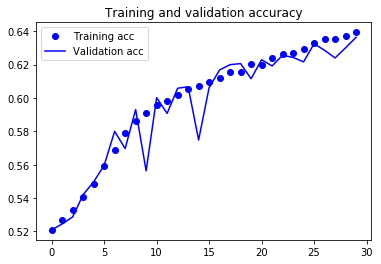

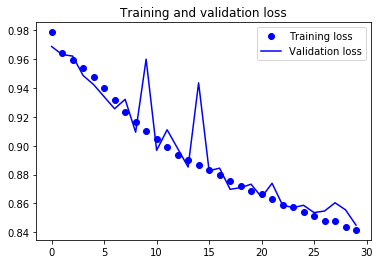

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
result = model.evaluate(test_data,test_labels)
print(result)

30000/30000 [==============================] - 36s 1ms/step
[0.8456556107521057, 0.6391333333333333]


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
test_pred = model.predict(test_data)

In [33]:
print(test_pred[0:100])
print(test_pred.argmax(axis=1)[0:100])

[[0.6203477  0.26320106 0.11645129]
 [0.5316132  0.33284208 0.13554478]
 [0.36817145 0.48992813 0.14190042]
 [0.12233826 0.7952394  0.08242235]
 [0.15361787 0.80755156 0.03883065]
 [0.678205   0.20563544 0.11615954]
 [0.37616408 0.47417596 0.14965999]
 [0.62139004 0.21868096 0.15992889]
 [0.00841169 0.97297734 0.01861095]
 [0.30124116 0.57974446 0.11901442]
 [0.5316132  0.33284208 0.13554478]
 [0.0147475  0.9510361  0.0342165 ]
 [0.14795053 0.76835155 0.08369787]
 [0.79806876 0.07892779 0.12300333]
 [0.57925457 0.28710547 0.13363999]
 [0.8267167  0.08132558 0.09195773]
 [0.7273447  0.13190258 0.14075278]
 [0.6465772  0.22174333 0.13167955]
 [0.801902   0.10524442 0.09285361]
 [0.5022146  0.364578   0.1332074 ]
 [0.5665852  0.27525738 0.15815748]
 [0.5316132  0.33284208 0.13554478]
 [0.41556686 0.45107162 0.1333615 ]
 [0.7128944  0.16888964 0.11821593]
 [0.7577245  0.11889633 0.12337921]
 [0.28992063 0.570807   0.13927239]
 [0.78348905 0.10262968 0.1138813 ]
 [0.49042776 0.32581547 0.18

In [34]:
matrix = confusion_matrix(test_labels.argmax(axis=1), test_pred.argmax(axis=1))
report = classification_report(test_labels.argmax(axis=1), test_pred.argmax(axis=1))

In [35]:
#print("True Positive",tp)
#print("True Negative",tn)
#print("False Positive",fp)
#print("False Negative",fn)
print(matrix)
print(report)

#ResultsFile.write(repr(matrix))
#ResultsFile.write('\n')
#ResultsFile.write(report)
#ResultsFile.close()

[[14561   890     4]
 [ 6006  4593    23]
 [ 3375   528    20]]
              precision    recall  f1-score   support

           0       0.61      0.94      0.74     15455
           1       0.76      0.43      0.55     10622
           2       0.43      0.01      0.01      3923

    accuracy                           0.64     30000
   macro avg       0.60      0.46      0.43     30000
weighted avg       0.64      0.64      0.58     30000

